# CS-472 Computer Vision
## Assignment 05: Particle Swarm Optimization Tracking
## By: <span style="color:orange">Ioannis Kaziales</span> ~ csdp1305
### Spring semester 2022-2023 (Due Date: 03/07/2023)

This file contains a **demo for part A** (using PSO to track a white circle in black background).
It contains in-depth visualization of the estimation process.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import *

np.random.seed(42)

After tinkering with different parameters (you can see the results in a video), I decided to use the following parameters for the **Particle Swarm Optimization** algorithm. They achieved the best tradeoff between computational efficency, speed and accuracy.

In [2]:
# PSO parameters
num_particles = 20
max_iterations = 100
stop_iterations = 10    # stop if no improvement after 15 iterations
c1 = 0.4                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.99            # decay of inertia

SAVE_IMGS: bool = False  # Set to True to save images to disk

if SAVE_IMGS:
    out_dir = 'demos_output/partA'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

# Testing on `dataset_1/frame_322`
Let's try to find the parameters of the circle for the frame 322.

From the instructions pdf, we know that the correct parameters for this frame are `[491, 600, 60]`. We can compare them with our own results.

### First, we load the image and plot the initial circle particles.

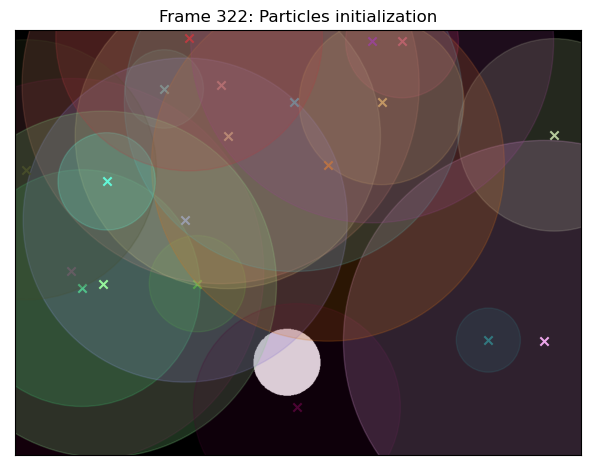

In [3]:
frame_num = 322
img = cv2.imread(f"askisi5_dataset1/dataset{frame_num}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img.shape[:2]
max_radius = min(x_max, y_max) / 2

particles = initialize_particles(img, num_particles, [x_max, y_max, max_radius])
colors = np.random.rand(num_particles, 3)

plot_iteration(img, particles, colors, f'Frame {frame_num}: Particles initialization')

Let's visualize a random particle that overlaps with the white circle. As an evaluation function, I used the **mean Intersect over Union** (mIoU) for the similarity of the images and `1 - mIoU` for the loss. In the following figure, we can see the image with the particle, the intersection and the union between them.

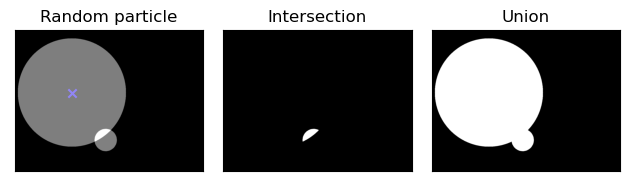

Intersection: 2896.0, Union: 278260.0, mIoU: 0.010


In [4]:
idx = 7
x, y, r = particles[idx].position
mask = np.zeros_like(img)
cv2.circle(mask, (int(x), int(y)), int(r), 255, -1)

interscection = np.bitwise_and(mask, img)
union = np.bitwise_or(mask, img)

plt.figure()
# 1st subplot: image with particle
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)
plt.scatter(x, y, color=colors[idx], marker='x')
plt.title('Random particle')
plt.xticks([])
plt.yticks([])
# 2nd subplot: intersection
plt.subplot(1, 3, 2)
plt.imshow(interscection, cmap='gray')
plt.title('Intersection')
plt.xticks([])
plt.yticks([])
# 3rd subplot: union
plt.subplot(1, 3, 3)
plt.imshow(union, cmap='gray')
plt.title('Union')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

score_intersect = np.sum(interscection) / 255
score_union = np.sum(union) / 255
mIoU = score_intersect / score_union
print(f"Intersection: {score_intersect}, Union: {score_union}, mIoU: {mIoU:.3f}")

### Let's run the PSO algorithm now
Since it is the first frame, we have no prior knowledge about the parameters of the circle

Iteration 1/100: Best fitness: 0.867:   0%|          | 0/100 [00:00<?, ?it/s]

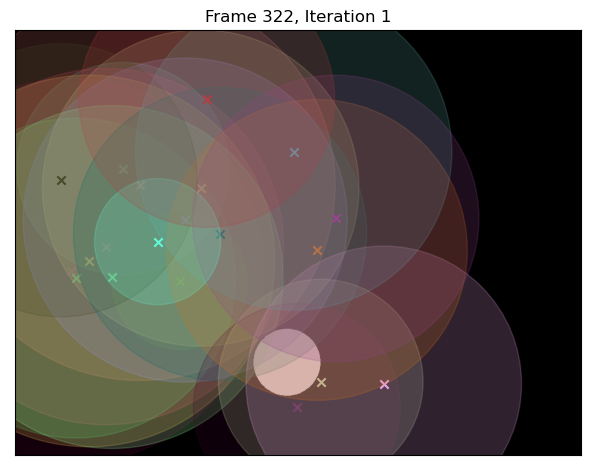

Iteration 11/100: Best fitness: 0.775:  10%|█         | 10/100 [00:00<00:07, 11.33it/s]

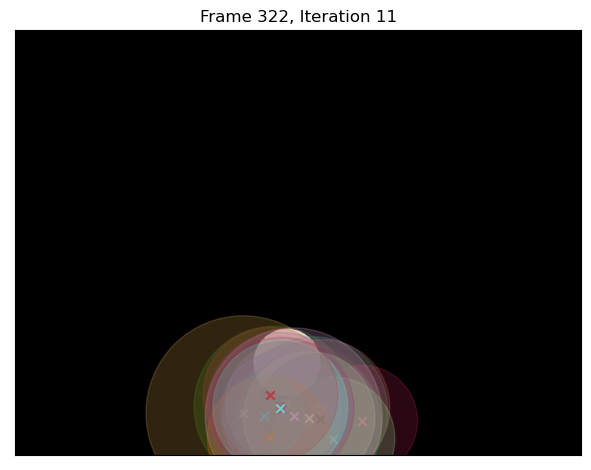

Iteration 21/100: Best fitness: 0.049:  20%|██        | 20/100 [00:01<00:07, 10.94it/s]

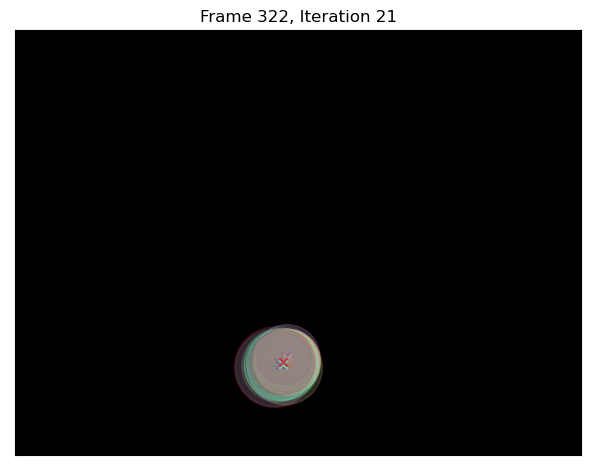

Iteration 31/100: Best fitness: 0.016:  30%|███       | 30/100 [00:02<00:06, 11.51it/s]

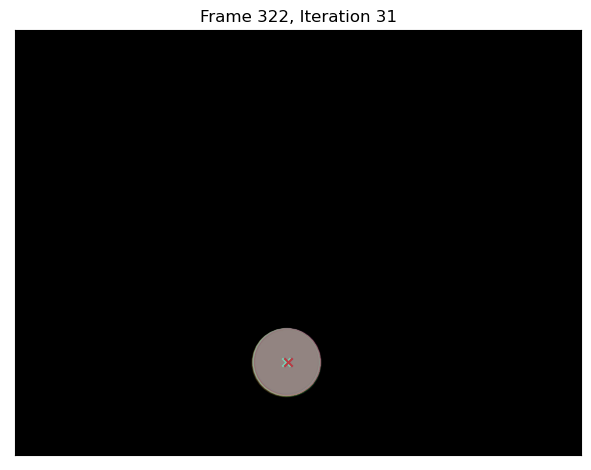

Iteration 35/100: Best fitness: 0.016:  34%|███▍      | 34/100 [00:03<00:06, 10.32it/s]

Stopping after 35 iterations with no improvement


In [5]:
file_prefix = f"frame{frame_num}"

global_best_position = None         # no prior knowledge about best position
global_best_fitness = float('inf')
losses = []
iters_no_improvement = 0

pbar = tqdm(range(max_iterations))
for iteration in pbar:
    pbar.set_description(f"Iteration {iteration+1}/{max_iterations}: Best fitness: {global_best_fitness:.3f}")
    iters_no_improvement += 1
    for particle in particles:
        # Evaluate fitness of particle's position
        fitness = evaluate_fitness(img, particle.position)
        # Update particle's best-known position
        if fitness < particle.best_fitness:
            particle.best_position = particle.position
            particle.best_fitness = fitness
        # Update global best position
        if fitness < global_best_fitness:
            global_best_position = particle.position
            global_best_fitness = fitness
            iters_no_improvement = 0
            pbar.set_description(f"Iteration {iteration+1}/{max_iterations}: Best fitness: {global_best_fitness:.3f}")
        # Update particle's velocity and position
        particle.velocity = (w * particle.velocity) +\
                (c1 * np.random.rand() * (particle.best_position - particle.position)) +\
                (c2 * np.random.rand() * (global_best_position - particle.position))
        particle.position = particle.position + particle.velocity
        # keep particle's position within bounds
        particle.position = np.clip(particle.position, 0, [x_max, y_max, max_radius]).astype(int)
    w = w * decay
    losses.append(global_best_fitness)
    if iters_no_improvement >= stop_iterations:
        print(f"Stopping after {iteration+1} iterations with no improvement")
        break
    show = not (iteration % 10) 
    #plot_iteration(img, particles, colors, f'Frame {frame_num}, Iteration {iteration+1}', show=False, save_filename=f'{out_dir}/{file_prefix}_{iteration}.png')
    plot_iteration(img, particles, colors, f'Frame {frame_num}, Iteration {iteration+1}', show=show, save_filename=None)

#make_video(out_dir, file_prefix, fps=5)

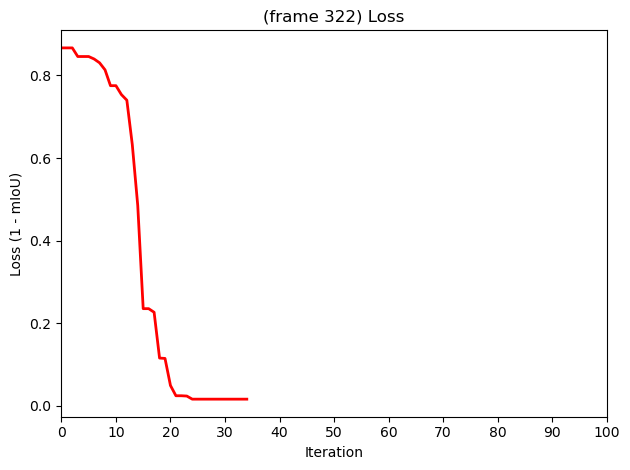

In [6]:
filename = None # f'{file_prefix}_loss.png'
plot_loss(losses, title=f'(frame {frame_num}) Loss', max_iterations=max_iterations, save_filename=filename)

Let's check the estimated parameters now
$\to$ Success!

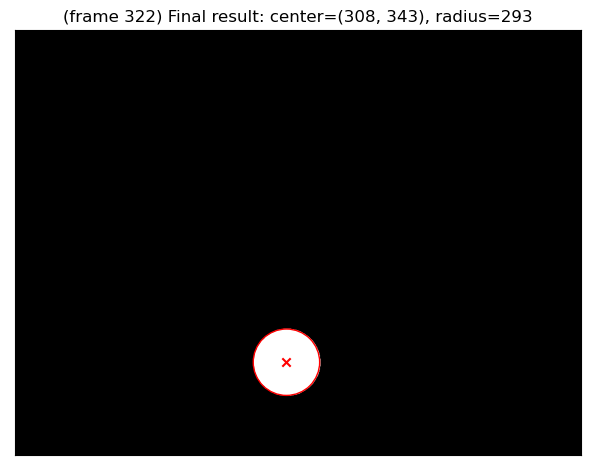

In [7]:
title = f"(frame {frame_num}) Final result: center=({x}, {y}), radius={r}"
plot_estimation(img, global_best_position, title=title, save_filename=None, est_type='circle')

## Next Image
Now, let's estimate the parameters for the next frame. First, we load the image and initialize the particles randomly

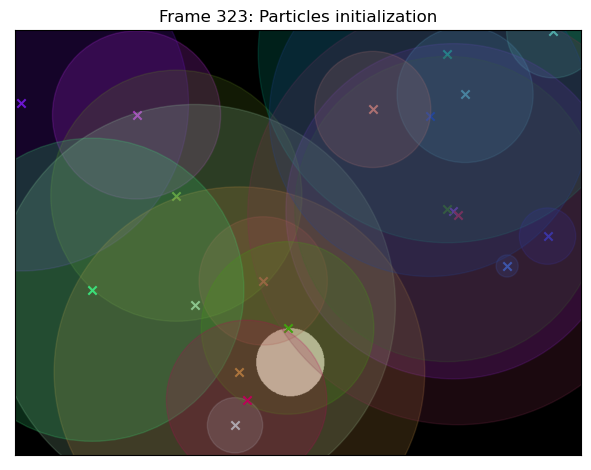

In [8]:
frame_num += 1
img = cv2.imread(f"askisi5_dataset1/dataset{frame_num}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img.shape[:2]
max_radius = min(x_max, y_max) / 2

particles = initialize_particles(img, num_particles, [x_max, y_max, max_radius])
colors = np.random.rand(num_particles, 3)

plot_iteration(img, particles, colors, f'Frame {frame_num}: Particles initialization')

Let's visualize the best global position found for the previous frame on the new frame

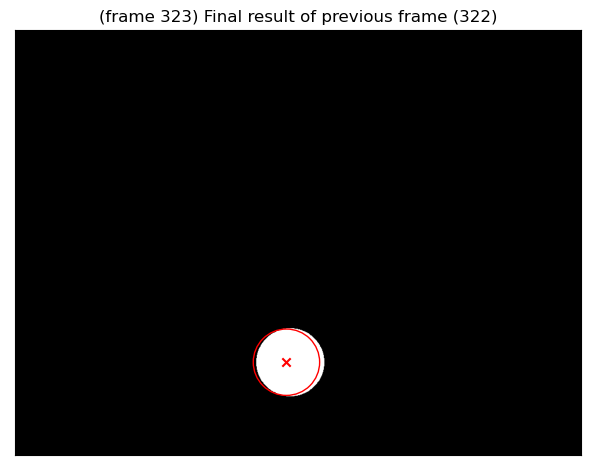

In [9]:
title = f"(frame {frame_num}) Final result of previous frame ({frame_num-1})"
plot_estimation(img, global_best_position, title=title, save_filename=None, est_type='circle')

### Temporally Smooth Movement
We can observe that circles in successive image frames have similar parameters. We can utilize this observation as prior knowledge for each new frame, given that we have successfully identified the circle from the previous frame. Specifically, the previous best global position can serve as an estimate for the new position. In addition to that, we can modify the parameters to achieve faster convergence!

Iteration 1/100: Best fitness: 0.123:   0%|          | 0/100 [00:00<?, ?it/s]

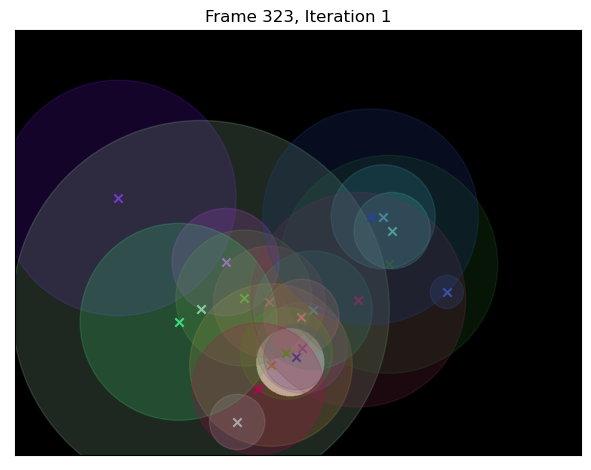

Iteration 11/100: Best fitness: 0.055:   9%|▉         | 9/100 [00:00<00:07, 11.58it/s]

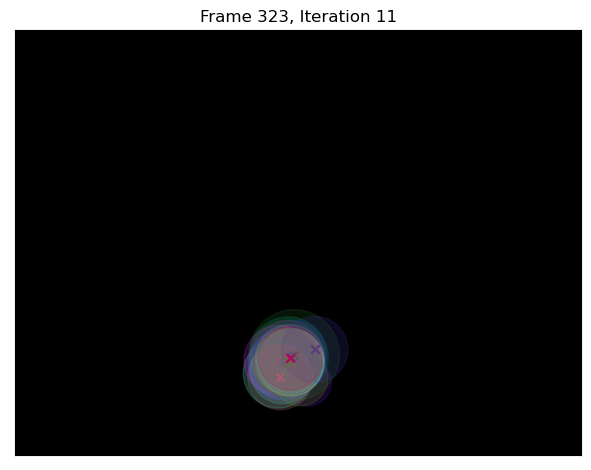

Iteration 19/100: Best fitness: 0.016:  18%|█▊        | 18/100 [00:01<00:07, 10.66it/s]

Stopping after 19 iterations with no improvement


In [10]:
num_particles = 20
max_iterations = 100
stop_iterations = 5 # stop if no improvement after 15 iterations
c1 = 0.4            # cognitive parameter
c2 = 1.0            # social parameter
w  = 0.7            # inertia weight
decay = 0.97        # decay of inertia

file_prefix = f"frame{frame_num}"

# global_best_position = None         # no prior knowledge about best position
# global_best_fitness = float('inf')
global_best_fitness = evaluate_fitness(img, global_best_position)
losses = []
iters_no_improvement = 0

pbar = tqdm(range(max_iterations))
for iteration in pbar:
    pbar.set_description(f"Iteration {iteration+1}/{max_iterations}: Best fitness: {global_best_fitness:.3f}")
    iters_no_improvement += 1
    for particle in particles:
        # Evaluate fitness of particle's position
        fitness = evaluate_fitness(img, particle.position)
        # Update particle's best-known position
        if fitness < particle.best_fitness:
            particle.best_position = particle.position
            particle.best_fitness = fitness
        # Update global best position
        if fitness < global_best_fitness:
            global_best_position = particle.position
            global_best_fitness = fitness
            iters_no_improvement = 0
            pbar.set_description(f"Iteration {iteration+1}/{max_iterations}: Best fitness: {global_best_fitness:.3f}")
        # Update particle's velocity and position
        particle.velocity = (w * particle.velocity) +\
                (c1 * np.random.rand() * (particle.best_position - particle.position)) +\
                (c2 * np.random.rand() * (global_best_position - particle.position))
        particle.position = particle.position + particle.velocity
        # keep particle's position within bounds
        particle.position = np.clip(particle.position, 0, [x_max, y_max, max_radius]).astype(int)
    w = w * decay
    losses.append(global_best_fitness)
    if iters_no_improvement >= stop_iterations:
        print(f"Stopping after {iteration+1} iterations with no improvement")
        break
    show = not (iteration % 10) 
    plot_iteration(img, particles, colors, f'Frame {frame_num}, Iteration {iteration+1}', show=show, save_filename=None)
    #plot_iteration(img, particles, colors, f'Frame {frame_num}, Iteration {iteration+1}', show=False, save_filename=f'{out_dir}/{file_prefix}_{iteration}.png')

#make_video(out_dir, file_prefix, fps=5)

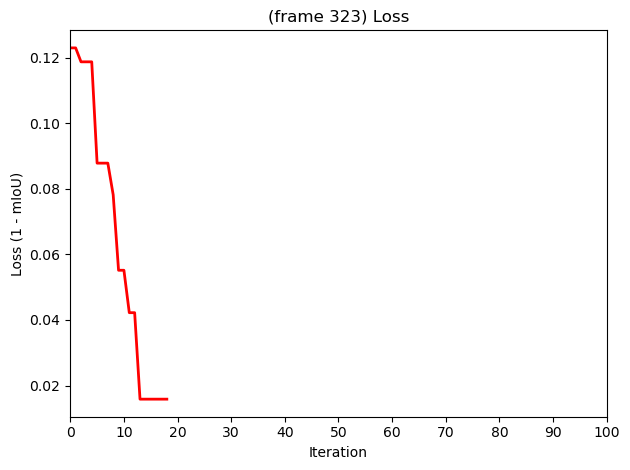

In [11]:
filename = None # f'{file_prefix}_loss.png'
plot_loss(losses, title=f'(frame {frame_num}) Loss', max_iterations=max_iterations, save_filename=filename)

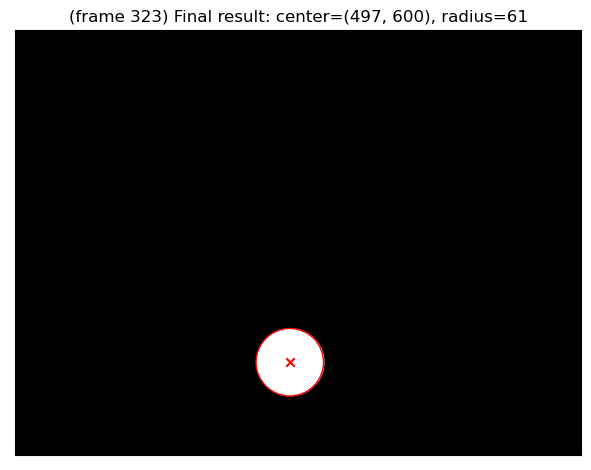

In [12]:
x, y, r = global_best_position
title = f"(frame {frame_num}) Final result: center=({x}, {y}), radius={r}"
plot_estimation(img, global_best_position, title=title, save_filename=None, est_type='circle')